In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size
plt.rc("animation", html="html5")
import random

random.seed(15)
import numpy as np

np.random.seed(15)

## Running Controlled Experiments

The simplest way to compare different agent designs is to run tournaments between them as explained in details in previous tutorials. Nevertheless, while developing an agent, it is beneficial to be able to run experiments in which you specify **exactly** some or all factors that may affect agent performance in order to analyze its behavior.

This tutorial will explain how to achieve this at different levels of control. As expected with more control comes more responsibility (and complexity). For this tutorial we will use the SCMLOneshot game but everthing we discuss applies exactly to all SCML environments. Moreover, we will use builtin agents for illustration but of course the same methods apply to any agents.

### Levels of control

There are four levels of control for world generation:

1. The tournament level: In this case you use `negmas.tournament` or --- more conveniently --- `scml.utils.anac2022_*` functions to run a tournament. You can adjust the parameters used to create worlds in this simulation using almost all the same parameters that are received by `SCML2020OneShotWorld.generate()` method (next level of control below). It is harder in this case to control the number of simulations and factory assignment.
2. You can use `SCML2020OneShotWorld.generate()` or `SCML2021World.generate()` method to generate a **single** world for which you can either allow the system to select agent types and their placement or with full control over those. Using this approach (recommended), you can control almost all aspects of the simulations except the **exact** exogenous contracts and profiles for agents.
3. Finally, you can just construct `SCML2020OneShotWorld` and `SCML2021World` objects directly which allows you to control everything including every single profile and exogenous contract.
4. You can subclass the world and override some of its private members to modify how the simulation runs. For example, you can override `_make_issues()` to change the ranges of issues for negotiations.

This tutorial will focus on the second approach and will touch upon the third.

### Using `generate()`:

There are two general ways to use the `generate()` method of SCML worlds for world generation:

1. You pass `random_agent_types=True`: In this case, you need only pass `agent_types` and the system will generate random simulations using these types. If you want a specific type to be more represented than others, just repeat it in the `agent_types` list. You can also pass `n_agents_per_process` to control how many agents are present on each production level but you cannot control the exact type of each one of them.
2. You pass `random_agent_types=False`: In this case, you need to pass `agent_types` and `agent_processes` (`n_agents_per_process` will be ignored). The former gives the type of each single agent in the simulation and the later gives the corresponding production level. This gives you full control over the type of agent controlling every single factory in the simulation.


We will see examples of both of these approaches in this tutorial. Let's first import in what we need:

In [2]:
from scml.oneshot.world import SCML2023OneShotWorld
from scml.oneshot.world import is_system_agent
from scml.oneshot.agents import GreedyOneShotAgent, GreedySingleAgreementAgent

### Controlling agent allocation to factories

You can control which agents are allocated to which factory by using the `generate()` method of the `SCML2020OneShotWorld` class (or any  SCML world class). Let's say that you want to have $10$ agents with the first two of type `GreedyOneShotAgent` and the rest of the type `GreedySingleAgreementAgentAgent`, here is a simple way to achieve that:

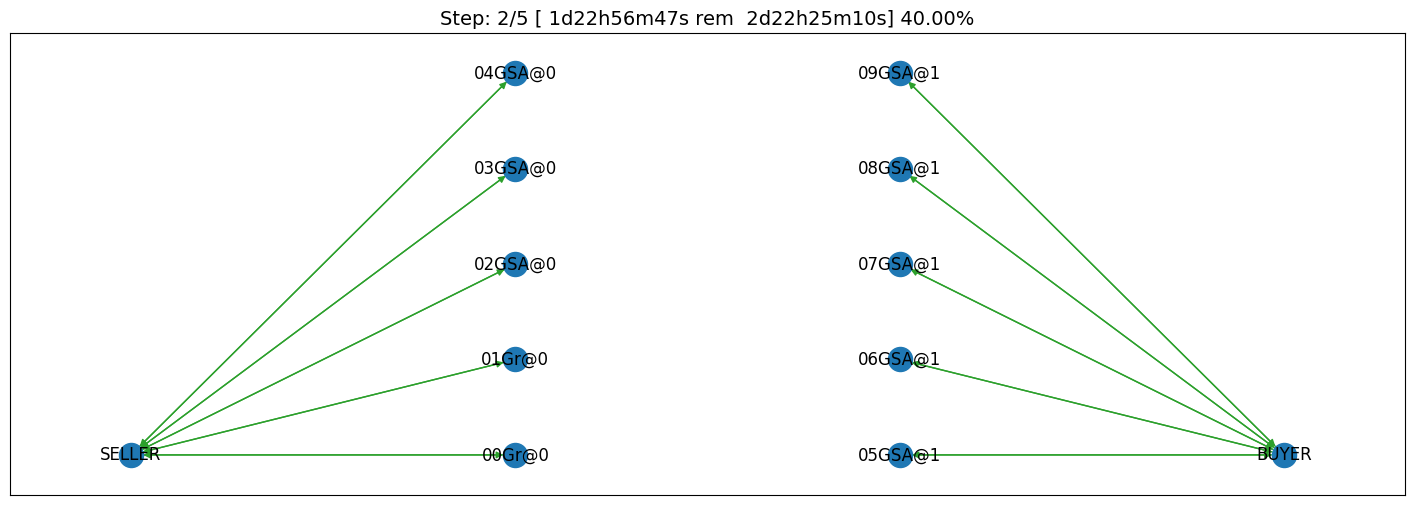

In [3]:
types = [GreedyOneShotAgent] * 2 + [GreedySingleAgreementAgent] * 8

world = SCML2023OneShotWorld(
    **SCML2023OneShotWorld.generate(
        agent_types=types,
        agent_processes=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        n_processes=2,
        n_steps=5,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()
world.run()
plt.show()

as you can see, the first two agents ("01Gre@0" and "00Gre@0") are of type `GreedyOneshotAgent` and the rest are of type `GreedySingleAgreementAgent`. That is clear from the naming convention of putting the first $3$ letters of the type before the `@` sign in the agent name. You can confirm it explicity by checking types:

In [4]:
[a._obj.__class__.__name__ for a in world.agents.values() if not is_system_agent(a.id)]

['GreedyOneShotAgent',
 'GreedyOneShotAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent',
 'GreedySingleAgreementAgent']

What happens if we want to create a world in which the number of agents at every level are different. Let's first try just extending the approach we used before:


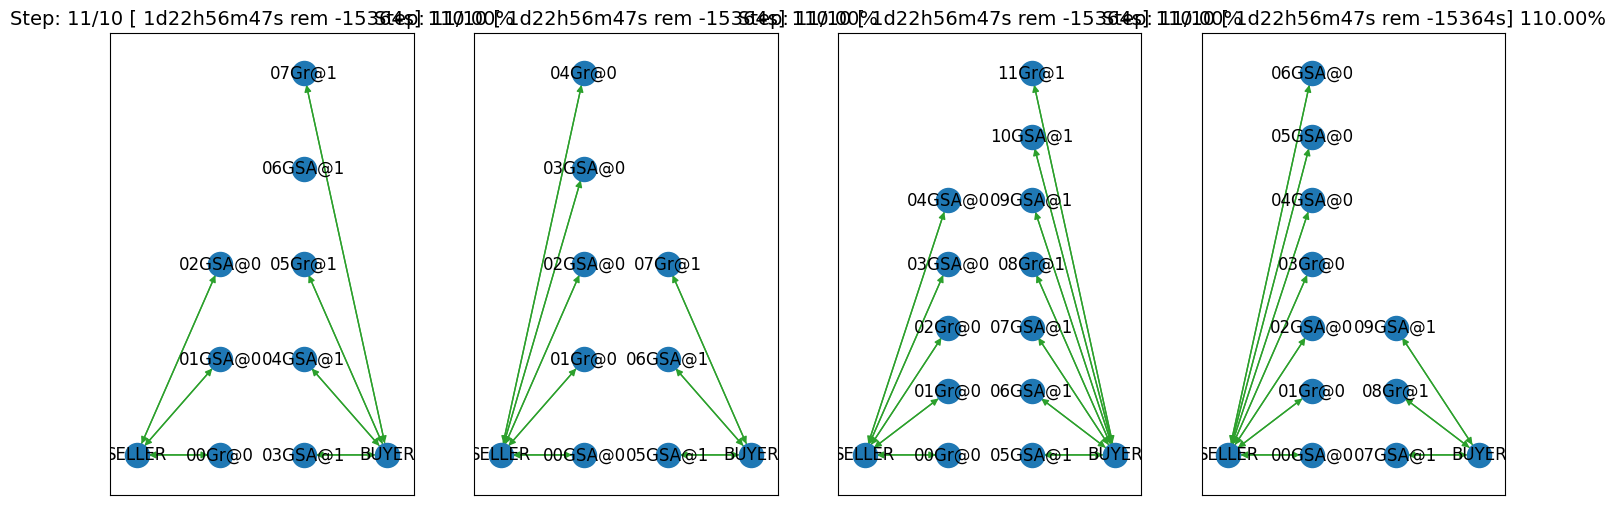

In [5]:
types = [GreedyOneShotAgent] * 2 + [GreedySingleAgreementAgent] * 8

fig, axs = plt.subplots(1, 4)
for ax in axs:
    world = SCML2023OneShotWorld(
        **SCML2023OneShotWorld.generate(
            agent_types=types,
            n_agents_per_process=(3, 7),
            n_processes=2,
            n_steps=10,
            construct_graphs=True,
        )
    )
    world.draw(axs=ax, steps=(0, world.n_steps), what=["contracts-concluded"])

We can run the last of these worlds just to be sure something happens!!

(<AxesSubplot: title={'center': 'Step: 10/10 [ 0s rem  0s] 100.00%'}>,
 <networkx.classes.multidigraph.MultiDiGraph at 0x2a40b52d0>)

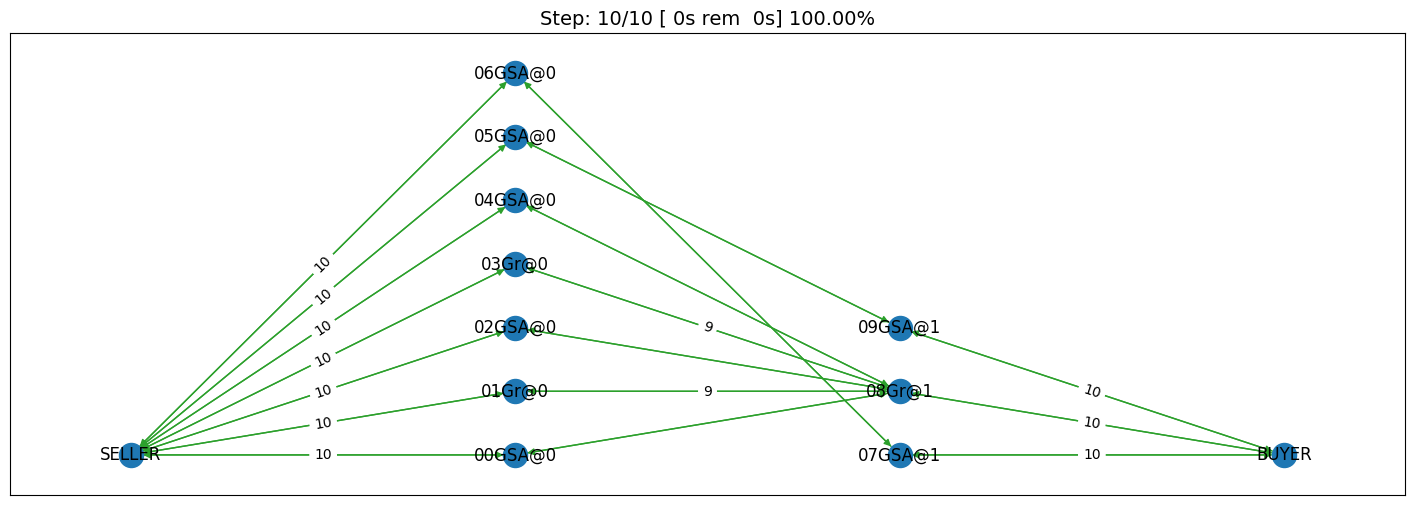

In [6]:
world.run()
world.draw(what=["contracts-concluded"], steps=(0, world.n_steps - 1))

As you can see, passing a tuple as `n_agents_per_process` did not help. We generated two world. They were different and neither had the distribution we wanted. That is because in this case, the generator will be guaranteed to make a world in which the number of agents in every level is **between 3 and 7** not exactly either of them.

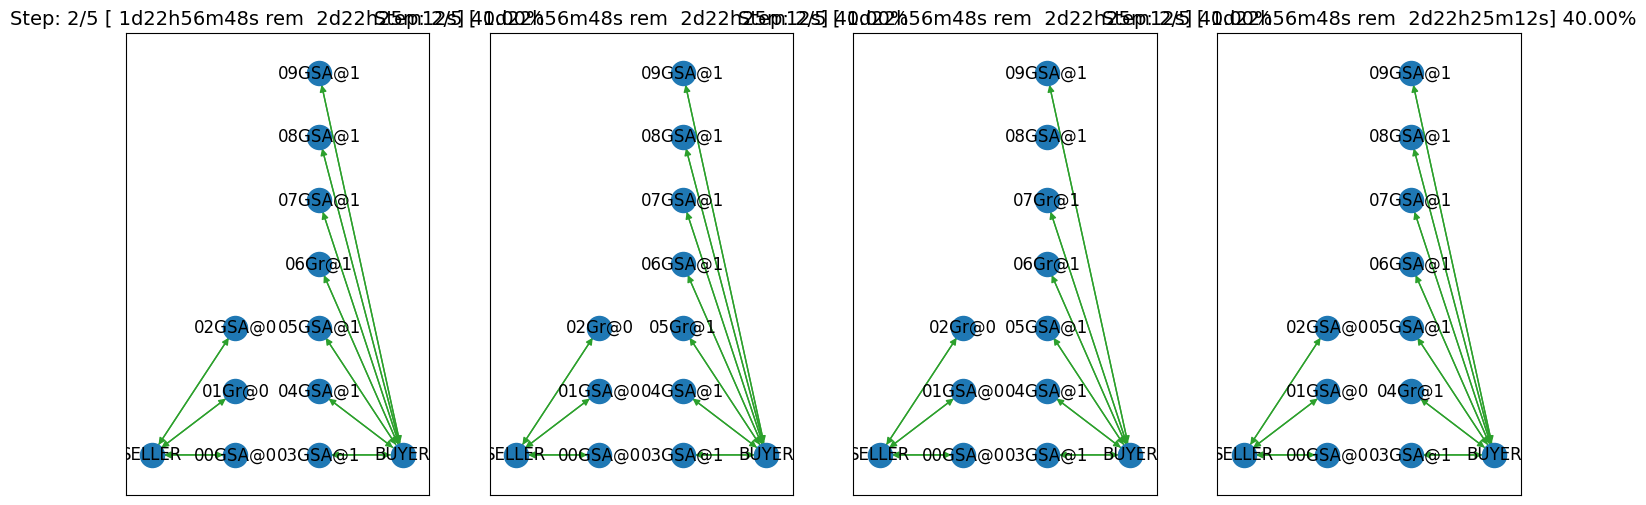

In [7]:
types = [GreedyOneShotAgent] * 2 + [GreedySingleAgreementAgent] * 8

fig, axs = plt.subplots(1, 4)
for ax in axs:
    world = SCML2023OneShotWorld(
        **SCML2023OneShotWorld.generate(
            agent_types=types,
            n_agents_per_process=[3, 7],
            n_processes=2,
            n_steps=5,
            construct_graphs=True,
        )
    )
    world.draw(axs=ax, what=["contracts-concluded"])

That works. We can also use it to generate deeper graphs of our choosing:

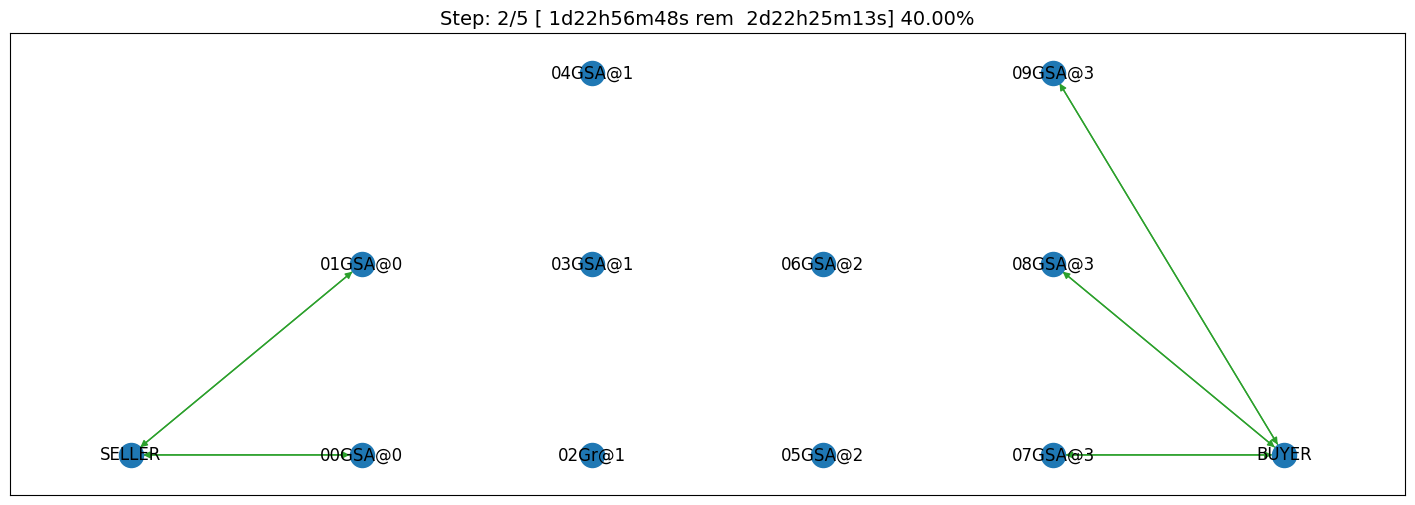

In [8]:
types = [GreedyOneShotAgent] * 2 + [GreedySingleAgreementAgent] * 8
agents_per_process = [2, 3, 2, 3]
world = SCML2023OneShotWorld(
    **SCML2023OneShotWorld.generate(
        agent_types=types,
        n_agents_per_process=agents_per_process,
        n_processes=len(agents_per_process),
        n_steps=5,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()

Exactly what the doctors ordered!


### Controlling construction paramteres

We have seen now that you can control the agent types. What about having agents of the same type but with different prarameters? You will need to do that for example if you want to compare different options for the initialization parameters of your agent. Because of a technical difference between the implementations of SCMLOneshot and standard SCML game, it is much easier to see what is going on in the `SCML2021World` case.

In this case, we can use the `agent_params` input to `generate()` as follows:


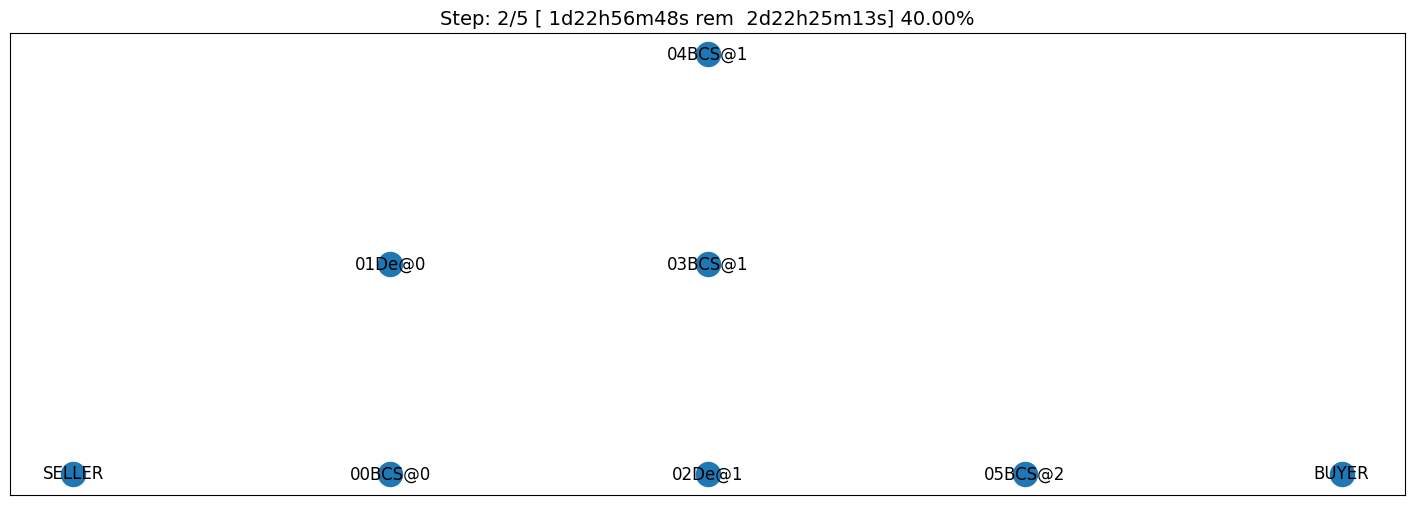

In [9]:
from scml.scml2020.world import SCML2023World
from scml.scml2020.agents import DecentralizingAgent, BuyCheapSellExpensiveAgent
from negmas import NaiveTitForTatNegotiator

types = [DecentralizingAgent] * 2 + [BuyCheapSellExpensiveAgent] * 4
params = [dict(negotiator_type=NaiveTitForTatNegotiator), dict()] + [dict()] * 4
agents_per_process = [2, 3, 1]
world = SCML2023World(
    **SCML2023World.generate(
        agent_types=types,
        agent_params=params,
        n_agents_per_process=agents_per_process,
        n_processes=len(agents_per_process),
        n_steps=5,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()

By just looking at the graph, we cannot be sure about what happened. Nevertheless, we can still check the construction parameters from the world itself:

In [10]:
print(world.agent_params[:-2])

[{}, {}, {}, {}, {}, {}]


We can see that the first agent had the negotiator-type we asked for and the rest are just getting their default initialization paramters.


For SCMLOneshot agents, the approach is slightly different due to the fact that the `OneShotAgent` is actually a `Controller` not an `Agent` in NegMAS's parallance. The exact meaning of this is not relevant for our current discussion though. What we care about is creating agents with controlled construction paramters. Let's try the same method:

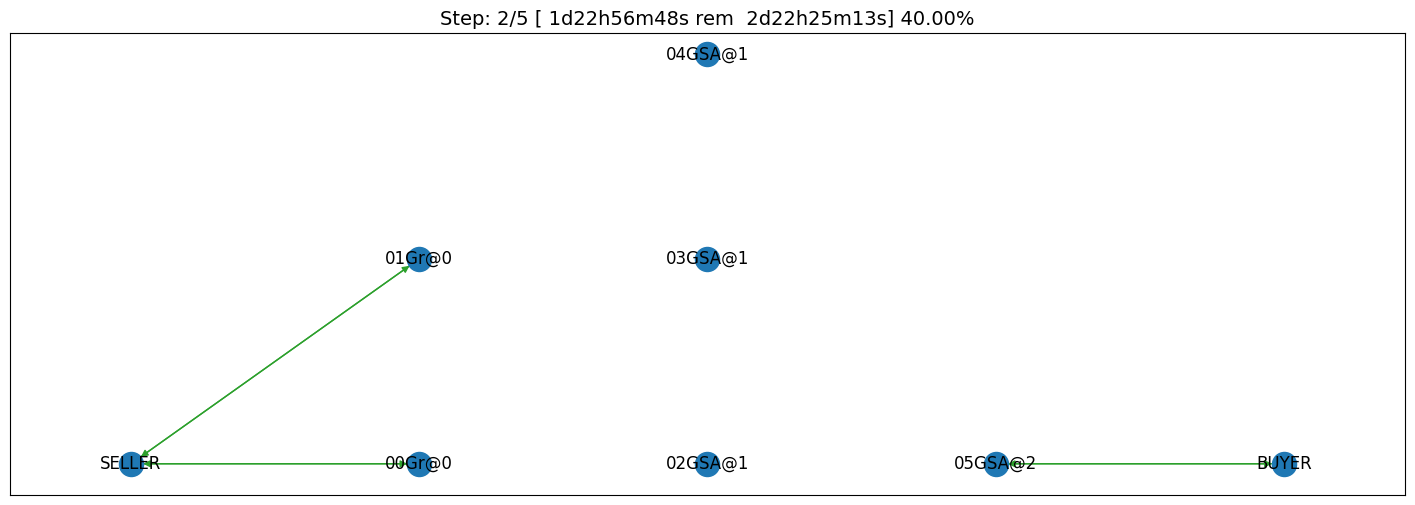

In [11]:
types = [GreedyOneShotAgent] * 2 + [GreedySingleAgreementAgent] * 4
params = [
    dict(controller_params=dict(concession_exponent=0.4)),
    dict(controller_params=dict(concession_exponent=3.0)),
] + [dict()] * 4
world = SCML2023OneShotWorld(
    **SCML2023OneShotWorld.generate(
        agent_types=types,
        agent_params=params,
        agent_processes=[0, 0, 1, 1, 1, 2],
        n_processes=3,
        n_steps=5,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()

Firstly, note that, in this case, we needed to encolose our paramters dict within another dict and pass it to the key `controller_params`. That is necessary as these paramters are not to be passed to the adapther used to run the agent within SCMLOneshot but to our agent which is the controller.

How can we check that it worked? Let's first try doing the same thing we did before and examing `agent_params` of the `world`:


In [12]:
print(world.agent_params[:-2])

[{}, {}, {}, {}, {}, {}]


No ... definitely not. The reason is that these are the paramters of the adapter not our controller. To confirm that the concession rate was passed correctly  to our agents, we need to check them directly as follows:

In [13]:
for a in list(world.agents.values())[:2]:
    print(a._obj._e)

0.4
3.0


Yes. That is what we expected. The first two agents have the concession exponents we passed to them.

### Controlling other aspects of the simulation

You can control other aspects of the simulation by passing specific paramters to the [generate()](https://scml.readthedocs.io/en/latest/api/scml.oneshot.SCML2020OneShotWorld.html?scml.oneshot.SCML2020OneShotWorld.generate#scml.oneshot.SCML2020OneShotWorld.generate) method or the [World constructor](https://scml.readthedocs.io/en/latest/api/scml.oneshot.SCML2020OneShotWorld.html?) directly. 

Here is an example in which we use `generate()` and fix the inital balance of all agents to $1000$ while fixing the production cost of everyone to $20$, increasing the number of production lines to $20$, and setting the number of simulation steps (days) to $40$ while making all negotiations go for $100$ steps instead of $20$ keeping the number of negotiation steps per day at $101$ which means that negotiations are still guaranteed to finish within the same day in which they are started. This configuration is very different than the one used by default in the official competition but you can decide to test it:

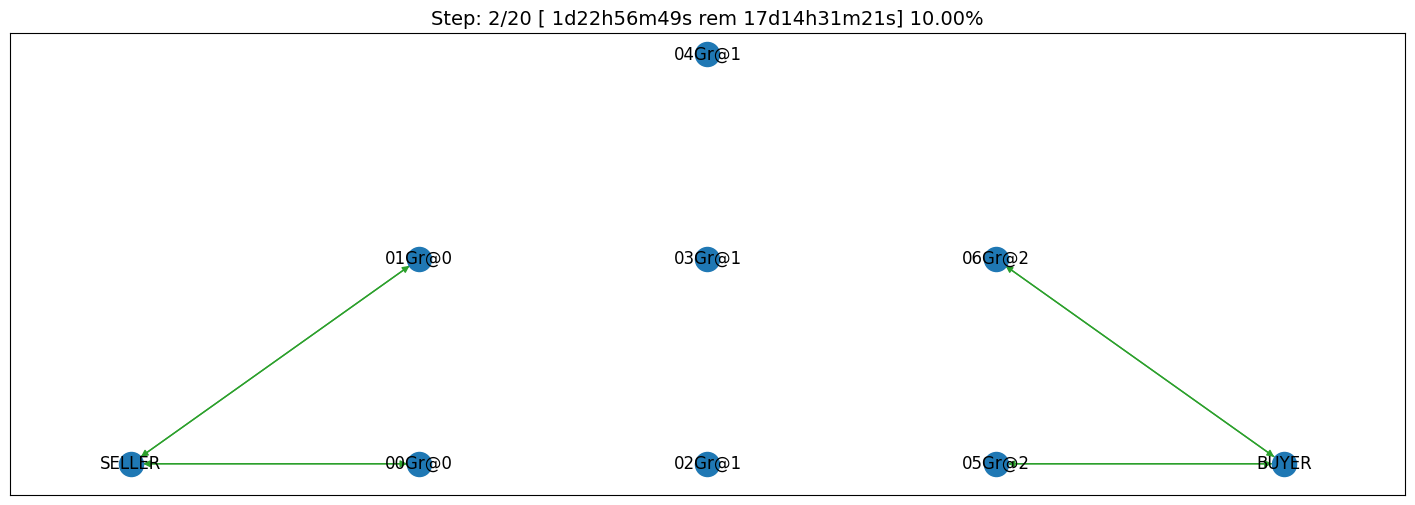

In [14]:
types = [GreedyOneShotAgent] * 7
agents_per_process = [2, 3, 2]
world = SCML2023OneShotWorld(
    **SCML2023OneShotWorld.generate(
        agent_types=types,
        n_agents_per_process=agents_per_process,
        n_processes=len(agents_per_process),
        n_steps=20,
        neg_n_steps=100,
        production_costs=50,
        cost_increases_with_level=False,
        initial_balance=1000,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()

It is easy enough to check that some of these paramters are correct. For example:

In [15]:
world.neg_n_steps

100

As expected. Checking the initial balances and production costs is harder. Let's look at the initial balances:

In [16]:
for a in world.agents.values():
    if is_system_agent(a.id):
        continue
    print(f"{a.id} -> {a.awi.current_balance}")

00Gr@0 -> 1000
01Gr@0 -> 1000
02Gr@1 -> 1000
03Gr@1 -> 1000
04Gr@1 -> 1000
05Gr@2 -> 1000
06Gr@2 -> 1000


As expected again. What about production cost?

In [17]:
for a in world.agents.values():
    if is_system_agent(a.id):
        continue
    print(f"{a.id} -> {a.awi.profile.cost}")

00Gr@0 -> 50
01Gr@0 -> 50
02Gr@1 -> 50
03Gr@1 -> 50
04Gr@1 -> 50
05Gr@2 -> 50
06Gr@2 -> 50


This time, we will run this world to just see that it still works after all of this mingling:

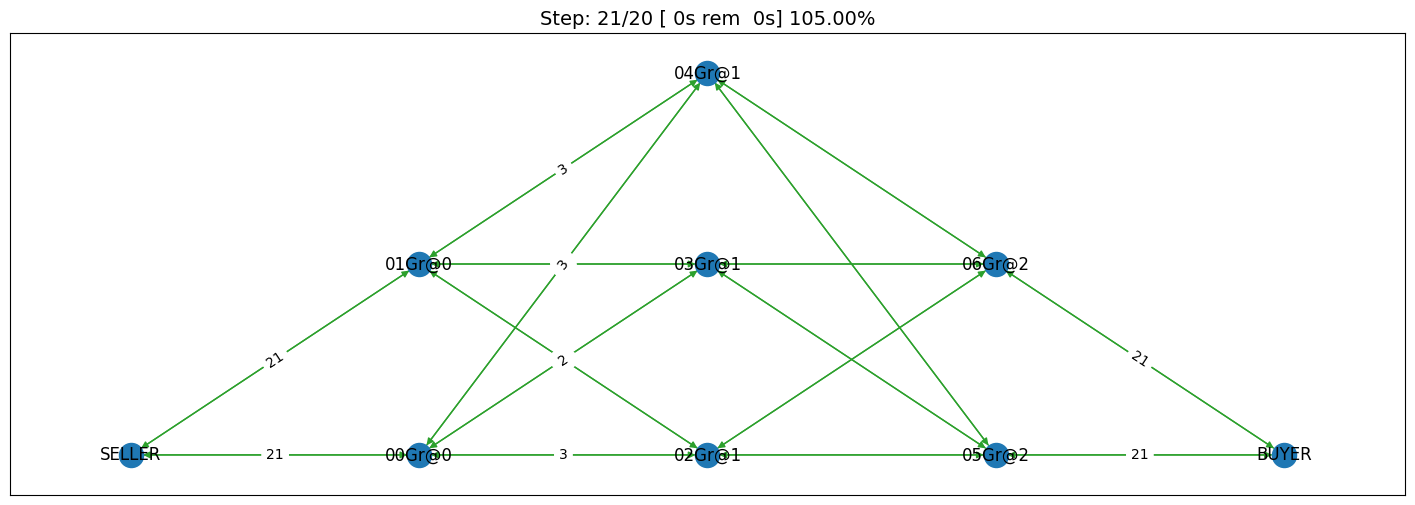

In [18]:
world.run()

world.draw(what=["contracts-concluded"], steps=(0, world.n_steps))
plt.show()

Seems fine.

### Controlling Profiles

In the previous example, we used `generae()` to do our bidding instead of directly calling the world constructore. Why? The main reason is that `generate()` creates profiles and exogenous contracts compatible with our settings so that it is possible --- in principly --- to make money in the generated world. Moreover, this is controllable by its parameters (see `profit_*` parameters [here](https://scml.readthedocs.io/en/latest/api/scml.oneshot.SCML2020OneShotWorld.html?scml.oneshot.SCML2020OneShotWorld.generate#scml.oneshot.SCML2020OneShotWorld.generate)). We can push things a little further by controlling the profile of each agent independently (which in this case is just its production cost). We will generate a world in which agents have costs from $1$ to $7$.


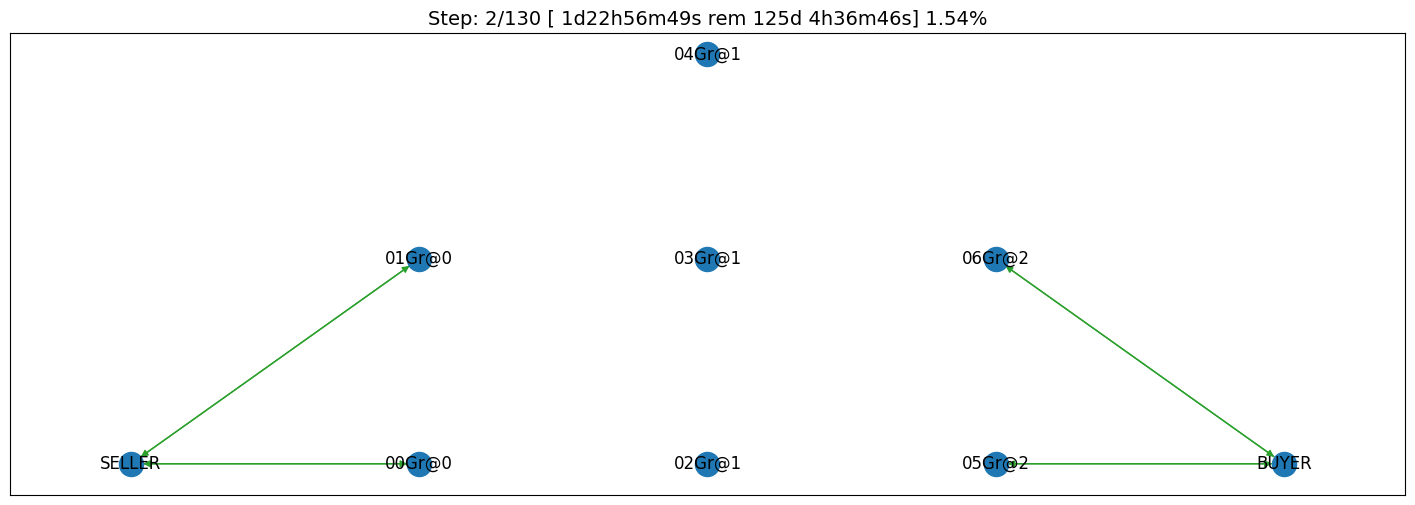

In [19]:
types = [GreedyOneShotAgent] * 7
agents_per_process = [2, 3, 2]
world = SCML2023OneShotWorld(
    **SCML2023OneShotWorld.generate(
        agent_types=types,
        n_agents_per_process=agents_per_process,
        n_processes=len(agents_per_process),
        production_costs=list(range(1, 8)),
        cost_increases_with_level=False,
        construct_graphs=True,
        random_agent_types=False,
    )
)

world.draw(what=["contracts-concluded"])
plt.show()

Let's now check the production costs:

In [20]:
for a in world.agents.values():
    if is_system_agent(a.id):
        continue
    print(f"{a.id} -> {a.awi.profile.cost}")

00Gr@0 -> 1
01Gr@0 -> 2
02Gr@1 -> 3
03Gr@1 -> 4
04Gr@1 -> 5
05Gr@2 -> 6
06Gr@2 -> 7


It is crucial here that we passed ```cost_increases_with_level=False```, otherwise, the system will just increase the costs of agents in the second and third production levels.

The disadvantage of this approach is that you cannot control **exactly** the exogenous contracts. These are generated by the `generate()` method for us. To control this final piece of the world, we need to directly call the world constructor. We will see now how to do that for both types of SCML worlds.

### Controlling exogenous contracts

Here we cannot use the `generate()` method and must call the world constructor directly. This is the most complex approach as we need to set everything up exactly right. 

#### Standard SCML2023World

Let's try to do it for the `SCML2023World` first:

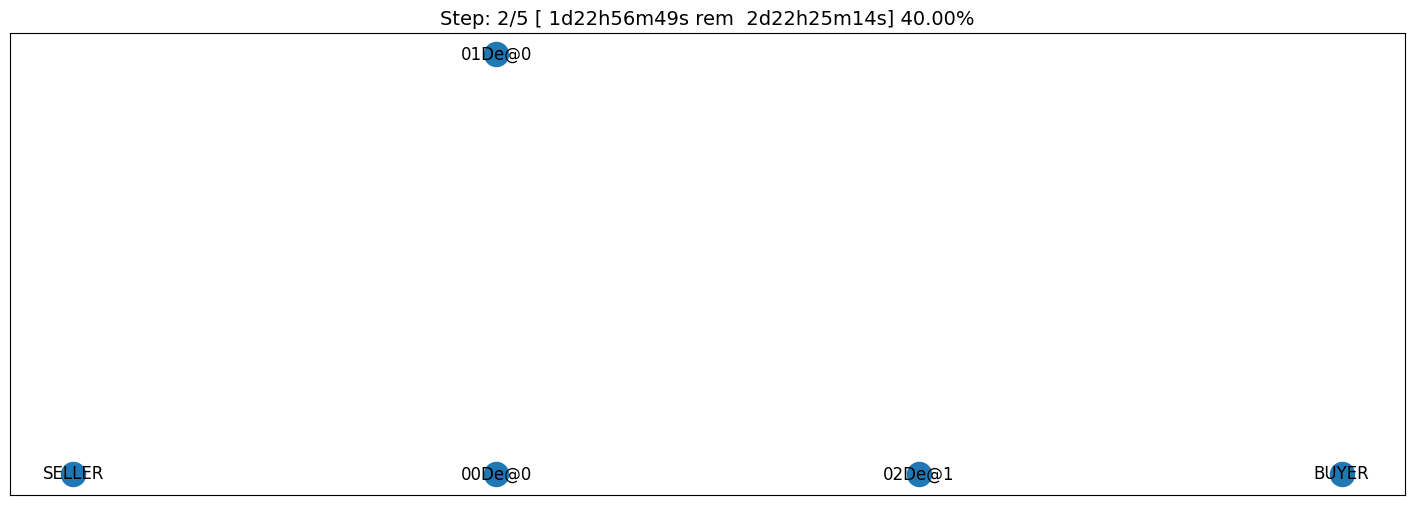

In [21]:
import numpy as np
from scml.scml2020.common import FactoryProfile
from scml.scml2020.common import INFINITE_COST, ExogenousContract

types = [DecentralizingAgent] * 3
agents_per_process = [2, 1]
n_processes = len(agents_per_process)
n_lines = 10

# setup the factory profiles. For each factory we
# set production cost to INFINITE_COST for all processes
# except the one it can actually run
profiles = [
    FactoryProfile(np.asarray([[3, INFINITE_COST]] * n_lines)),
    FactoryProfile(np.asarray([[20, INFINITE_COST]] * n_lines)),
    FactoryProfile(np.asarray([[INFINITE_COST, 5]] * n_lines)),
]

# create exogenous contracts
exogenous = [
    ## exogenous supply
    ExogenousContract(
        product=0,
        quantity=10,
        unit_price=5,
        time=1,
        revelation_time=1,
        seller=-1,
        buyer=0,
    ),
    ExogenousContract(
        product=0,
        quantity=10,
        unit_price=7,
        time=2,
        revelation_time=0,
        seller=-1,
        buyer=0,
    ),
    ## exogenous sales
    ExogenousContract(
        product=0,
        quantity=10,
        unit_price=5,
        time=1,
        revelation_time=0,
        seller=2,
        buyer=-1,
    ),
]

world = SCML2023World(
    process_inputs=np.ones(n_processes),
    process_outputs=np.ones(n_processes),
    catalog_prices=[10, 20, 30],
    profiles=profiles,
    agent_types=types,
    agent_params=[dict()] * 3,
    exogenous_contracts=exogenous,
    n_steps=5,
    construct_graphs=True,
    agent_name_reveals_position=True,
    agent_name_reveals_type=True,
)

world.draw(what=["contracts-concluded"])
plt.show()

Let's check the exogenous contracts in the system then explain what just happened:

In [22]:
from pprint import pprint

pprint(
    list(
        (
            list(str(_) for _ in contracts)
            for s, contracts in world.exogenous_contracts.items()
        )
    )
)

[["Contract(agreement={'time': 1, 'quantity': 10, 'unit_price': 5}, "
  "partners=('00De@0', 'SELLER'), annotation={'seller': 'SELLER', 'buyer': "
  "'00De@0', 'caller': 'SELLER', 'is_buy': False, 'product': 0}, issues=(), "
  'signed_at=-1, executed_at=-1, concluded_at=-1, nullified_at=-1, '
  'to_be_signed_at=1, signatures={}, mechanism_state=None, mechanism_id=None, '
  "id='9891315c-fc0c-4bcc-92f5-6e0cc90012c1')"],
 ["Contract(agreement={'time': 2, 'quantity': 10, 'unit_price': 7}, "
  "partners=('00De@0', 'SELLER'), annotation={'seller': 'SELLER', 'buyer': "
  "'00De@0', 'caller': 'SELLER', 'is_buy': True, 'product': 0}, issues=(), "
  'signed_at=-1, executed_at=-1, concluded_at=-1, nullified_at=-1, '
  'to_be_signed_at=0, signatures={}, mechanism_state=None, mechanism_id=None, '
  "id='da0ab71e-079c-4628-b82f-14dd3dc574e7')",
  "Contract(agreement={'time': 1, 'quantity': 10, 'unit_price': 5}, "
  "partners=('BUYER', '02De@1'), annotation={'seller': '02De@1', 'buyer': "
  "'BUYER'

You can confirm for yourself that this is exactly what we expected.

Let's first discuss the profile. In `SCML2021World`, an agent's profile consists of the production cost **per line per product**. You can see the full definition [here](https://scml.readthedocs.io/en/latest/api/scml.scml2020.FactoryProfile.html). That is why we needed to create a 2D array of costs.

Exogenous contract structure is self explanatory. You have to specify the product, delivery time, quantity, and unit price. Moreover, you have to specify the time at which this contract is revealed to its agent (which must be before or at the delivery time step). The one thing you should be careful about is setting the *buyer* to $-1$ for exogenous sales and the *seller* to $-1$ for exogenous supplies. You can in principle have exogenous contracts in the middle of the chain but we do not do that usually.

Let's try to run this world

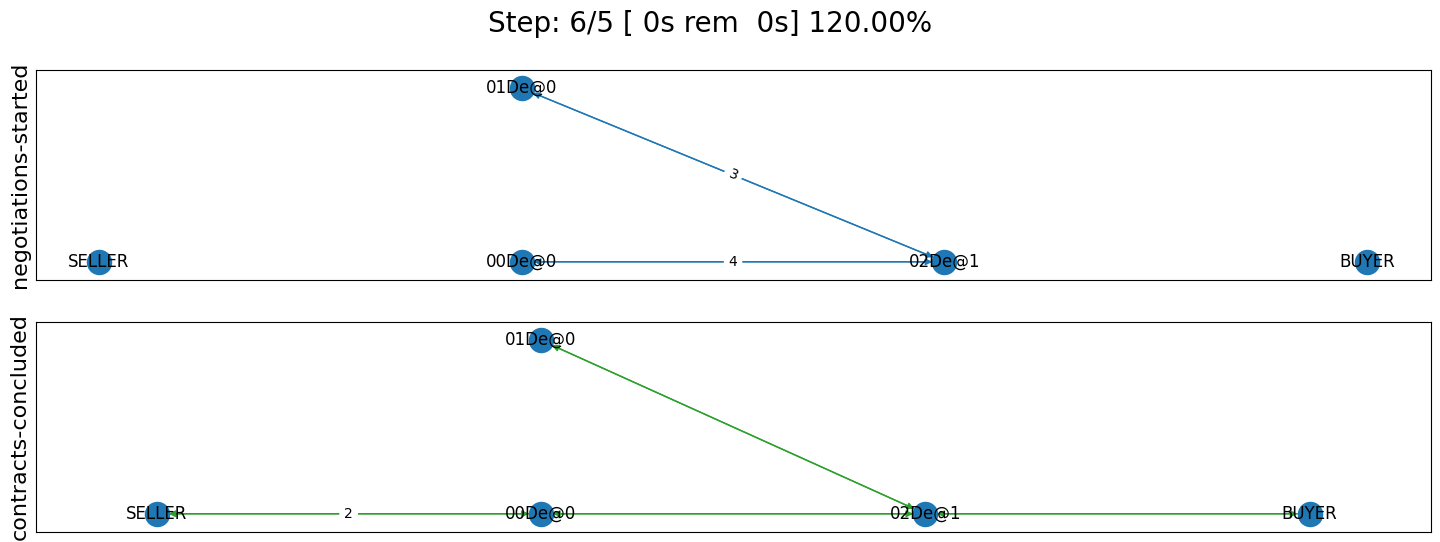

In [23]:
world.run()

_, axs = plt.subplots(2)
world.draw(
    what=["negotiations-started", "contracts-concluded"],
    steps=(0, world.n_steps),
    together=False,
    axs=axs,
)
plt.show()

We can see that there were $2$ concluded exogenous supply contracts and $1$ concluded exogenous sale contracts. We can also see that there were $7$ negotiations in total in this world none of them leading to contracts.

#### SCMLOneshot World

The situation is slightly different for the SCMLOneshot world just because the format of the profile and exogenous contract data structures is slightly different. Here is an example case:


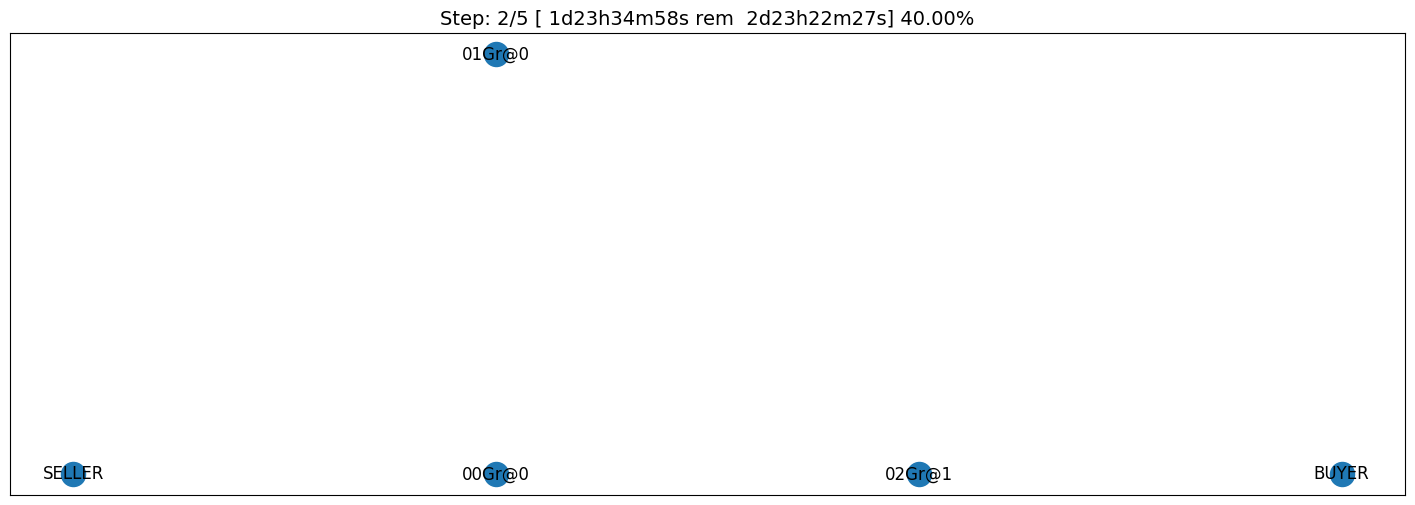

In [25]:
import numpy as np
from scml.oneshot import OneShotProfile
from scml.oneshot import OneShotExogenousContract
from scml.oneshot import DefaultOneShotAdapter

types = [DefaultOneShotAdapter] * 3
params = [dict(controller_type=GreedyOneShotAgent)] * 3
agents_per_process = [2, 1]
n_processes = len(agents_per_process)
n_lines = 10
common = dict(
    n_lines=10,
    shortfall_penalty_mean=0.2,
    disposal_cost_mean=0.1,
    shortfall_penalty_dev=0.01,
    disposal_cost_dev=0.01,
    storage_cost_mean=0.0,
    storage_cost_dev=0.0,
)
# setup the factory profiles. For each factory we
profiles = [
    OneShotProfile(cost=3, input_product=0, **common),
    OneShotProfile(cost=10, input_product=0, **common),
    OneShotProfile(cost=7, input_product=1, **common),
]

# create exogenous contracts
exogenous = [
    ## exogenous supply
    OneShotExogenousContract(
        product=0,
        quantity=10,
        unit_price=5,
        time=1,
        revelation_time=1,
        seller=-1,
        buyer=0,
    ),
    OneShotExogenousContract(
        product=0,
        quantity=10,
        unit_price=7,
        time=2,
        revelation_time=0,
        seller=-1,
        buyer=0,
    ),
    ## exogenous sales
    OneShotExogenousContract(
        product=0,
        quantity=10,
        unit_price=5,
        time=1,
        revelation_time=0,
        seller=2,
        buyer=-1,
    ),
]

world = SCML2023OneShotWorld(
    catalog_prices=[10, 20, 30],
    profiles=profiles,
    agent_types=types,
    agent_params=params,
    exogenous_contracts=exogenous,
    n_steps=5,
    construct_graphs=True,
    agent_name_reveals_position=True,
    agent_name_reveals_type=True,
)

world.draw(what=["contracts-concluded"])
plt.show()

The world is constructed. Lets run it and see what happens:

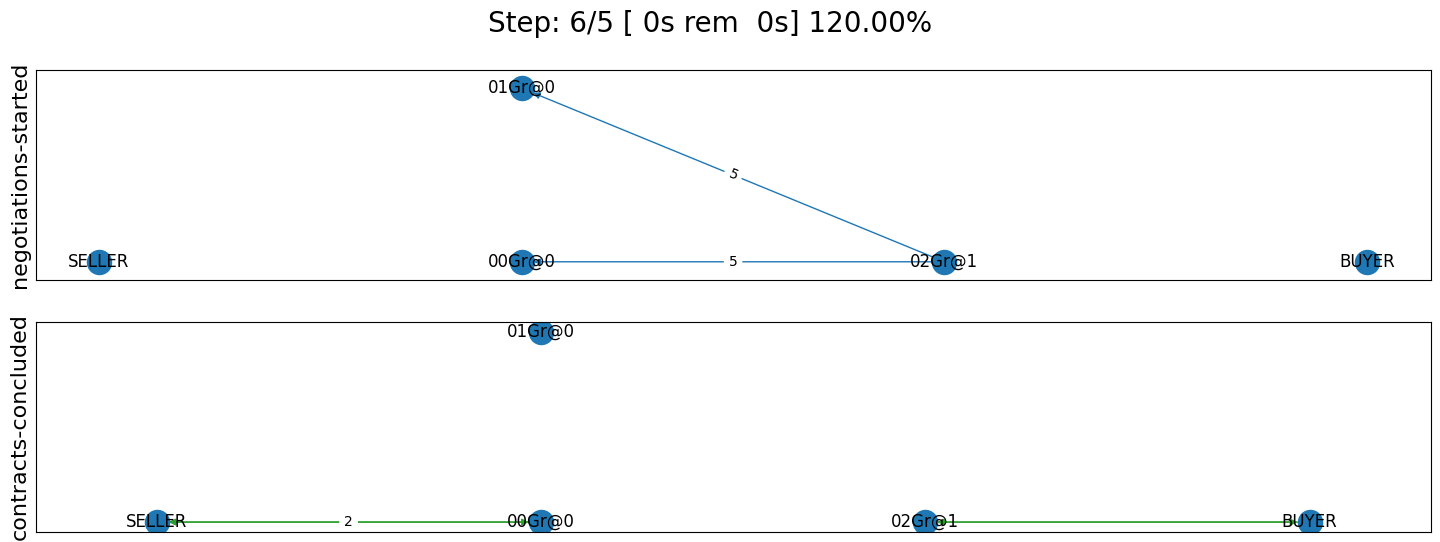

In [26]:
world.run()

_, axs = plt.subplots(2)
world.draw(
    what=["negotiations-started", "contracts-concluded"],
    steps=(0, world.n_steps),
    together=False,
    axs=axs,
)
plt.show()

You can confirm for yourself that this is what we expected. Let's dive into the details.

Firstly, in this case, we need to pass `agent_params` to the constructor (because `OneshotAgent` is a controller and not an `Agent` which means it needs an adapter to run. Here we use the default `DefaultOneshotAdapter`:

```python
types = [DefaultOneShotAdapter] * 3
params = [
    dict(controller_type=GreedyOneShotAgent)
] * 3
```

The real agent type we want is to be passed in `controller_type`.

The profile in this case has a different structure than the previous case to match the [game description](http://www.yasserm.com/scml/scml2021oneshot.pdf). Other than the production cost, we also need to pass the parameters of Gaussians describing shortfall penalties and disposal costs.

Other than these two differences, the rest is almost the same as in the previous case.